In [1]:
import pytorch_lightning as pl
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torchvision.datasets import DatasetFolder
from torchvision import transforms
from torch.utils.data import Subset
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import wandb
import albumentations as alb
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
project_name='CNN_NATURALIST_'
wandb.login(key="5bfaaa474f16b4400560a3efa1e961104ed54810")
wandb.init(project=project_name)

wandb: Currently logged in as: aravind_iitm. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\PhysioSens\.netrc


In [2]:
###function for loading the image

def load(path):
    img=cv2.imread(path)
    img=cv2.resize(img,(224,224),cv2.INTER_AREA)
    img=img/255
    return img


In [3]:
###path for train and test####
train_path=r'D:\DL_DATA\naturalist\inaturalist_12K\train'
test_path=r'D:\DL_DATA\naturalist\inaturalist_12K\val'


In [4]:
transforms=transforms.ToTensor()


In [5]:
###loading the train and test data as torch tensors###
train_data_=DatasetFolder(root=train_path,loader=load,extensions='.jpg',transform=transforms)
test_data=DatasetFolder(root=test_path,loader=load,extensions='.jpg',transform=transforms)


In [6]:

####taking the indices for train and val so that number of image in each class is same#####
train_indx=[]
val_indx=[]
for i in range(0,len(train_data_),1000):
    train_indx+=list(range(i,i+800))
    val_indx+=list(range(i+800,i+1000))
val_indx=val_indx[0:-1]

In [7]:
#####splitting the 20% of train data into val data
train_data=Subset(dataset=train_data_,indices=train_indx)
val_data=Subset(dataset=train_data_,indices=val_indx)

In [8]:
###### creating data loader for train, val and test
train_loader=DataLoader(train_data,batch_size=64,shuffle=True,drop_last=True)
val_loader=DataLoader(val_data,batch_size=64,shuffle=True,drop_last=True)
test_loader=DataLoader(dataset=test_data,batch_size=64,shuffle=True,drop_last=True)

In [9]:
#### using albumentation library for augmentation
from torchvision import transforms
augmentor=transforms.Compose([
    transforms.RandomHorizontalFlip(p=.2),
    transforms.RandomVerticalFlip(p=.2),
    transforms.RandomAutocontrast(p=.2),
    transforms.RandomRotation(degrees=(-10,10)),
    transforms.RandomAdjustSharpness(sharpness_factor=0,p=.2),
    transforms.Resize((224,224))
])

In [10]:
####python class for the model, this model takes in the number of filter, filter size, whether to do batch_norm or not
##, the drop_out probability, activation funtion and number of neuron in the hidden layer as the argument
class CNN_CLASSIFER(nn.Module):
    def __init__(self,num_filter=[3,64,64,64,64,64],filter_size=3,batch_norm=False,drop_out=.2,act=nn.ReLU(),neuron=128):
        super().__init__()
        self.FILTER_NUM=num_filter
        self.filter_size=filter_size
        self.SEQUENTIAL=nn.ModuleList()
        self.activation=act
        self.drop_out=drop_out
        self.batch_norm=batch_norm
        self.neuron=neuron
        for i in range(0,5):
            seq=nn.Sequential(
                nn.Conv2d(self.FILTER_NUM[i],self.FILTER_NUM[i+1],kernel_size=filter_size),
                self.activation,
                nn.MaxPool2d(kernel_size=2)
            )
            if self.batch_norm:
                seq.add_module(f'batch_norm{i+1}',nn.BatchNorm2d(self.FILTER_NUM[i+1]))
            
            self.SEQUENTIAL.append(seq)
        self.drop_OUT=nn.Dropout(p=self.drop_out)
        self.fc1 = nn.Linear(self.FILTER_NUM[-1] * 5 * 5, self.neuron)
        self.fc2 = nn.Linear(self.FILTER_NUM[-1] * 3 * 3, self.neuron)
        self.fc3=nn.Linear(self.neuron,10)
        self.softmax=nn.Softmax(dim=1)
        
    def forward(self,x):
        for i in range(0,5):
            x=self.SEQUENTIAL[i](x)

        x=self.drop_OUT(x)
            
        b,c,w,h=x.shape
        x=x.reshape(b,c*w*h)
        
        
        
        if self.filter_size==3:
            x=self.fc1(x)
        elif self.filter_size==5:
            x=self.fc2(x)
        x=self.fc3(x)
            
        
        
        
        ypred=self.softmax(x)
        
            
        return ypred
        
        

In [11]:
#### This pytorch lightning used for training the model, this takes in the number of filter, filter size,organisatio
##whether to do batch_norm or not,the drop_out probability, activation funtion and number of neuron in the hidden layer
###, the optimizer as the argument
class CNN_NATURALIST(pl.LightningModule):
    def __init__(self,num_filter=64,filter_size=3,organisation='same',data_aug=False,batch_norm=False,drop_out=.2,
                act='ReLU',log=False,lr=1e-4,neuron=128,optimizer='adam'):
        super().__init__()
        print(num_filter,filter_size,organisation,data_aug,batch_norm,drop_out,
                act,log,lr,neuron,optimizer)
        self.num_filter=num_filter
        self.filter_size=filter_size
        self.organisation=organisation
        self.data_aug=data_aug
        self.batch_norm=batch_norm
        self.drop_out=drop_out
        self.act=act
        FILTER_NUM=[self.num_filter]
        self.wandb_log=log
        self.lr=lr
        self.neuron=neuron
        self.optimizer_=optimizer
        for i in range(0,4):
            if self.organisation=='same':
                FILTER_NUM.append(self.num_filter)
            elif self.organisation=='doubling':
                FILTER_NUM.append(int(FILTER_NUM[i]*(2)))
            elif self.organisation=='halving':
                FILTER_NUM.append(int(FILTER_NUM[i]/(2)))
            else:
                raise ValueError('Unidentified organisation')
        FILTER_NUM.insert(0,3)
        self.FILTER_NUM=FILTER_NUM
        
        if self.act=='ReLU':
            self.activation=nn.ReLU()
        elif self.act=='GELU':
            self.activation=nn.GELU()
        elif self.act=='SiLU':
            self.activation=nn.SiLU()
        elif self.act=='Mish':
            self.activation=nn.Mish()
        else:
            raise ValueError(' activation function not found')
        
        self.model=CNN_CLASSIFER(num_filter=FILTER_NUM,filter_size=self.filter_size,batch_norm=self.batch_norm,
                                 drop_out=self.drop_out,act=self.activation,neuron=self.neuron)
        
        self.loss_fun=nn.CrossEntropyLoss()
        if self.optimizer_=='adam':
            self.optimizer=torch.optim.Adam(self.parameters(),lr=self.lr)
        elif self.optimizer_=='sgd':
            self.optimizer=torch.optim.SGD(self.parameters(),lr=self.lr)
        else:
            raise ValueError('Optimizer is not in the list')
        self.train_loss=[]
        self.train_acc=[]
        self.val_loss=[]
        self.val_acc=[]
        
    def forward(self,x):     ####training happens in this function
        
        ypred=self.model(x)
            
        return ypred
    def training_step(self,batch,batch_indx):
        global img
        img,label=batch
        img=img.float()
        if self.data_aug:
            img=[augmentor(img_) for img_ in img]
            img=torch.stack(img)
                
            
        
        ypred=self(img)
        
        loss=self.loss_fun(ypred,label)
        
        accuracy=(torch.argmax(ypred,dim=1)==label).sum()     
        
        accuracy=accuracy/len(ypred)
        
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True) ###calculating train_loss after each batch
        self.log('train_accuracy', accuracy, on_step=False, on_epoch=True, prog_bar=True)###calculating in the train_accuracy after each batch
        self.train_loss.append(loss.cpu().detach().numpy())
        self.train_acc.append(accuracy.cpu().detach().numpy())
        
        return loss
    
    def on_train_epoch_end(self):
        epoch_loss=np.average(self.train_loss)
        epoch_accuracy=np.average(self.train_acc)
        
        
        self.train_loss.clear()
        self.train_acc.clear()
        
        if self.wandb_log:
            wandb.log({"Train_Accuracy":np.round(epoch_accuracy*100,2),"Train_Loss":epoch_loss})
            ### logging train accuracy and loss in wandb
        
    def validation_step(self,batch,batch_indx):
        img,label=batch
        img=img.float()
        
        ypred=self(img)
        
        loss=self.loss_fun(ypred,label)
        
        accuracy=(torch.argmax(ypred,dim=1)==label).sum()
        
        accuracy=accuracy/len(ypred)
        
        self.log('val_loss', loss,prog_bar=True) ###logging in the val_loss after each batch
        self.log('val_accuracy', accuracy,prog_bar=True) ###logging in the val_accuracy after each batch
        self.val_loss.append(loss.cpu().detach().numpy())
        self.val_acc.append(accuracy.cpu().detach().numpy())
        
        return loss
    
    def on_validation_epoch_end(self):
        epoch_loss=np.average(self.val_loss)
        epoch_accuracy=np.average(self.val_acc)
        
        
        self.val_loss.clear()
        self.val_acc.clear()
        
        if self.wandb_log:
            wandb.log({"Val_Accuracy":np.round(epoch_accuracy*100,2),"Val_Loss":epoch_loss,"Epoch":self.current_epoch})
            ### logging val accuracy and loss in wandb
        
            
    def configure_optimizers(self):
        return [self.optimizer]

In [13]:
sweep_config={
    'method':'bayes',
    'metric':{
        'name':'Val_Accuracy',
        'goal':'maximize'},

}



parameters_dict={
    'num_filter':{
        'values':[32,64]
    },
    'filter_size':{
        'values':[3,5]
    },
    'organisation':{
        'values':['same','doubling','halving']
    },
    'data_aug':{
        'values':[True,False]
    },
    'batch_norm':{
      'values':[True,False]  
    },
    'drop_out':{
        'values':[.2,.3]
    },
    'act':{
        'values':['ReLU','GELU','SiLU','Mish']
    },
    'epochs':{
        'values':[10,15,20]
    },
    'lr':{
        'values':[1e-3,1e-4,1e-5]
    },
    'neuron':{
        'values':[128,256,512]
    },
    'optimizer':{
        'values':['sgd','adam']
    }
}
sweep_config['parameters']=parameters_dict
#### chocie of paramters for hyper parameter tuning 

In [14]:
#### creating a function for the training the pytorch lightning model
def train_NN(num_filter=64,filter_size=3,organisation='same',data_aug=False,batch_norm=False,drop_out=.2,
                act='ReLU',log=False,epochs=20,lr=1e-4,neuron=128,optimizer='sgd'):
    model=CNN_NATURALIST(num_filter=num_filter,filter_size=filter_size,organisation=organisation,
                         data_aug=data_aug,batch_norm=batch_norm,drop_out=drop_out,act=act,log=log,lr=lr,neuron=neuron,
                        optimizer=optimizer)
    trainer=pl.Trainer(accelerator='auto',max_epochs=epochs)
    trainer.fit(model,train_loader,val_loader)


In [15]:

def train():
    wandb.init()
    config=wandb.config
    wandb.run.name = "numfilter_"+str(config.num_filter)+"_filtersize_"+str(config.filter_size)+"_data_aug_"+str(config.data_aug)+"_bn_"+str(config.batch_norm)                                         
    parameters=train_NN(num_filter=config.num_filter,filter_size=config.filter_size,organisation=config.organisation,data_aug=config.data_aug,
                        batch_norm=config.batch_norm,drop_out=config.drop_out,act=config.act,log=True,epochs=config.epochs,
                        lr=config.lr,neuron=config.neuron,optimizer=config.optimizer)
    
    wandb.finish()


In [ ]:
wandb.init()
sweep_id=wandb.sweep(sweep_config,project=project_name)
wandb.agent(sweep_id,train)
wandb.finish()

In [17]:
monitor=ModelCheckpoint(monitor='val_accuracy',save_top_k=1,mode='max')

In [18]:
def train_NN(num_filter=64,filter_size=3,organisation='same',data_aug=False,batch_norm=False,drop_out=.2,
                act='ReLU',log=False,epochs=20,lr=1e-4,neuron=128,optimizer='sgd'):
    model=CNN_NATURALIST(num_filter=num_filter,filter_size=filter_size,organisation=organisation,
                         data_aug=data_aug,batch_norm=batch_norm,drop_out=drop_out,act=act,log=log,lr=lr,neuron=neuron,
                        optimizer=optimizer)
    trainer=pl.Trainer(accelerator='auto',max_epochs=epochs)
    trainer.fit(model,train_loader,test_loader)
parameters=train_NN(num_filter=32,filter_size=3,organisation='doubling',data_aug=True,batch_norm=True,drop_out=.3,act='SiLU',
                    log=False,epochs=20,lr=1e-4,neuron=128,optimizer='adam')

32 3 doubling True True 0.3 SiLU False 0.0001 128 adam


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | activation | SiLU             | 0     
1 | model      | CNN_CLASSIFER    | 3.8 M 
2 | loss_fun   | CrossEntropyLoss | 0     
------------------------------------------------
3.8 M     Trainable params
0         Non-trainable params
3.8 M     Total params
15.201    Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\PhysioSens\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
C:\Users\PhysioSens\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
C:\Users\PhysioSens\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.


In [12]:
model=CNN_NATURALIST(num_filter=32,filter_size=3,organisation='doubling',data_aug=True,batch_norm=True,drop_out=.3,act='SiLU',log=False,neuron=128,
                        optimizer='adam')
model.load_state_dict(torch.load(r'C:\Users\PhysioSens\Desktop\python-jupyter\CS6910\CNN\lightning_logs\version_20\checkpoints\epoch=19-step=2500.ckpt')['state_dict'])

32 3 doubling True True 0.3 SiLU False 0.0001 128 adam


<All keys matched successfully>

In [32]:
count=0
images=[]
pred_class=[]
label_class=[]
for img, label in test_data:
    #if label==9:
    img=img.unsqueeze(0)
    img=img.float()
    pred=model(img)
    pred=torch.argmax(pred,axis=1)
    img=img.cpu().detach().numpy()
    img=img[0]
    img=np.transpose(img,(1,2,0))
    images.append(img)
    pred_class.append(pred.item())
    label_class.append(label)
    count+=1
    '''
    if count==3:
        break
    '''
pred_class=np.array(pred_class)
label_class=np.array(label_class)

In [16]:
def img_view(img):
    img=img.cpu().detach().numpy()
    img=img[0]
    img=np.transpose(img,(1,2,0))
    return img
    

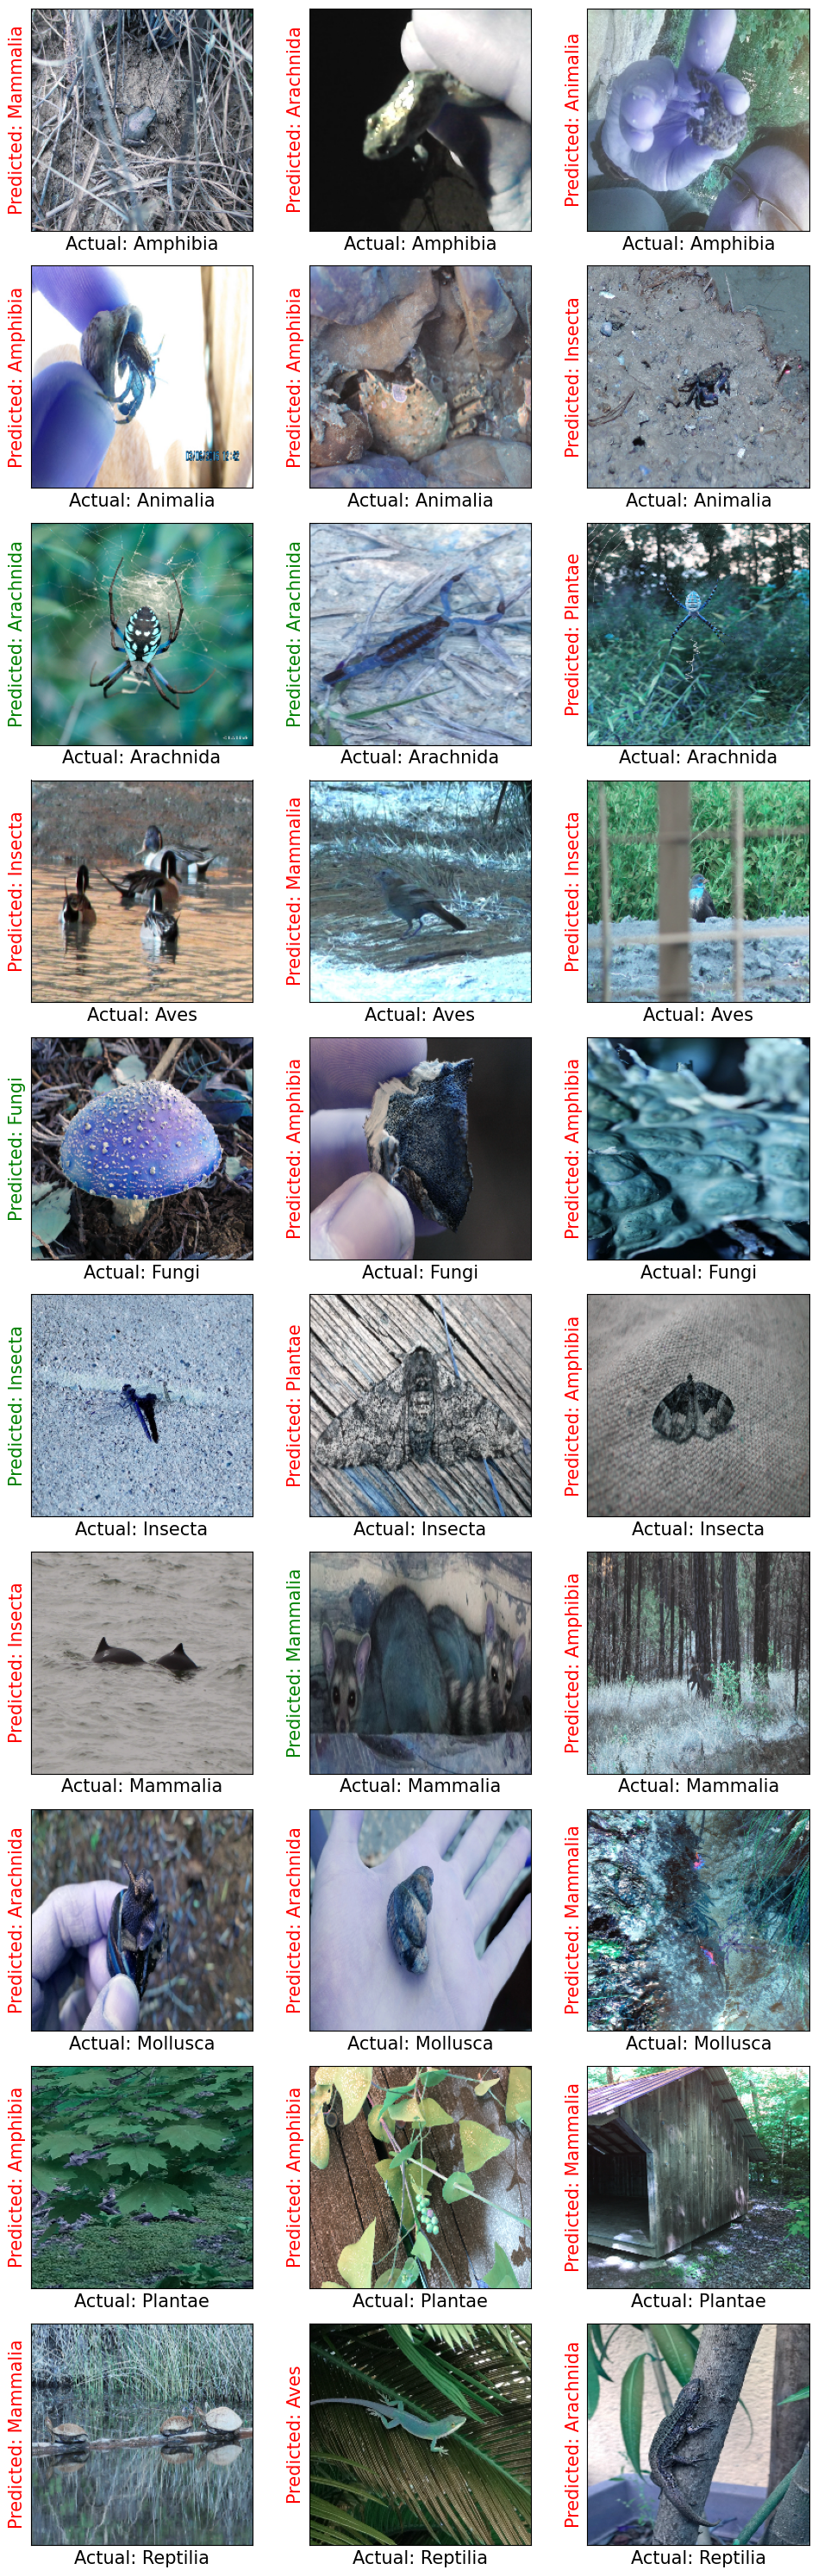

In [27]:
classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
#for img,label in test_loader:
fig,axs=plt.subplots(10,3,figsize=(10,30))
count=0
for i in range(0,10):
    for img, label in test_data:
        if label==i:
            img=img.unsqueeze(0)
            img=img.float()
            pred=model(img)
            pred=torch.argmax(pred,axis=1)
            img=img_view(img)
            axs[i][count].imshow(img)
            axs[i][count].set_xticks([])
            axs[i][count].set_yticks([])
            if label==pred:
                axs[i][count].set_xlabel(f'Actual: {classes[i]}',fontsize=15)
                axs[i][count].set_ylabel(f'Predicted: {classes[pred]}',color='green',fontsize=15)
            else:
                axs[i][count].set_xlabel(f'Actual: {classes[i]}',fontsize=15)
                axs[i][count].set_ylabel(f'Predicted: {classes[pred]}',color='red',fontsize=15)
            count+=1
        if count==3:
            count=0
            break
plt.tight_layout()
plt.savefig('wandb_img.png')

In [18]:
count

3

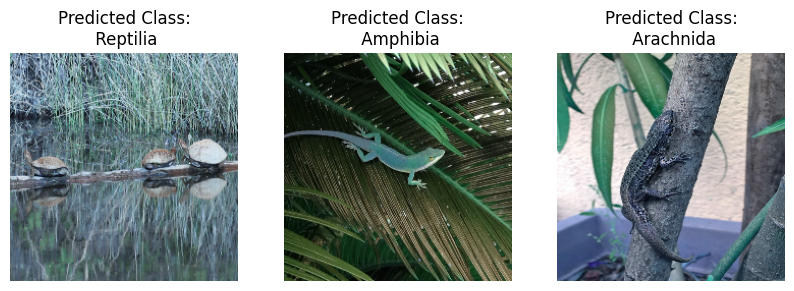

In [153]:
fig,axs=plt.subplots(1,3,figsize=(10,5))
for i,ax in enumerate(axs.flatten()):
    ax.imshow(images[i])
    ax.set_title(f'Predicted Class:\n {classes[pred_class[i]]}')
    ax.axis('off')
plt.savefig('Reptilia.png')

In [61]:
classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
#for img,label in test_loader:
    

In [112]:
wandb.log({'examples':[wandb.Image(img,caption=f'Predicted Class:\n {classes[lab]}') for img,lab in zip(images,pred_class)]})